# Spaceship Titanic 🚀

In this competition the task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, we are given a set of personal records recovered from the ship's damaged computer system.

## Imports
Importing all the libraries needed for preprocessing

In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', font_scale=2)
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [3]:
# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
test =  pd.read_csv("../titanc_spaceship/test.csv")
train = pd.read_csv("../titanc_spaceship/train.csv")

# Exploring Data

In [5]:
r1,c1 = train.shape
print('The training data has {} rows and {} columns'.format(r1,c1))
r2,c2 = test.shape
print('The validation data has {} rows and {} columns'.format(r2,c2))

The training data has 8693 rows and 14 columns
The validation data has 4277 rows and 13 columns


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [8]:
test.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

## Duplicated Values

Let us check if there are duplicate values, if so we remove them

In [9]:
train.duplicated().sum()

0

In [10]:
test.duplicated().sum()

0

## Missing Values

Checking for missing values. If there are we will choose to impute, or drop.

<AxesSubplot:>

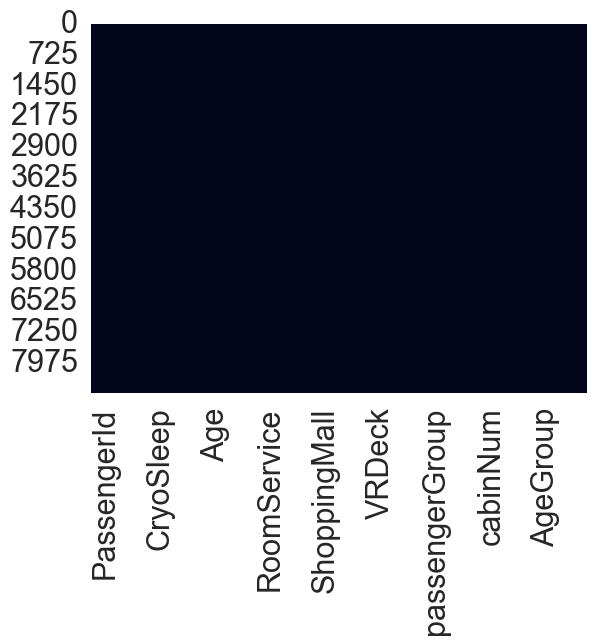

In [121]:
#heatmap for missing values
sns.heatmap(train.isnull(), cbar=False)

<AxesSubplot:>

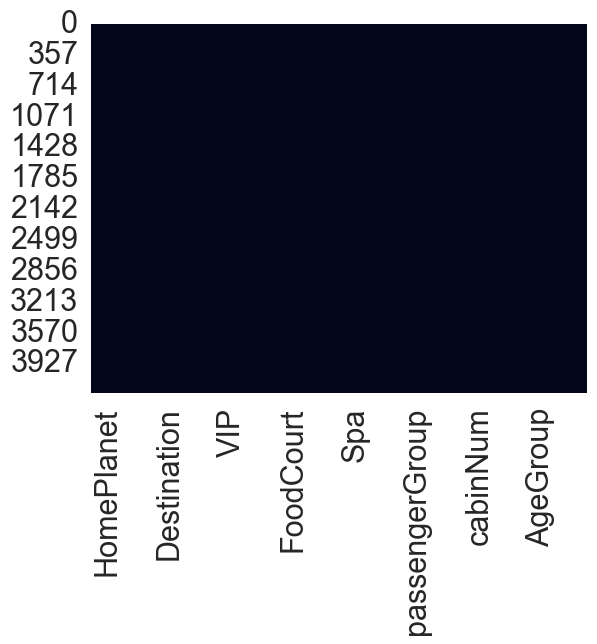

In [122]:
sns.heatmap(test.isnull(), cbar=False)

In [11]:
train.isnull().sum().sort_values(ascending=False)/len(train) *100

CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
PassengerId     0.000000
Transported     0.000000
dtype: float64

In [12]:
test.isnull().sum().sort_values(ascending=False)/len(test) *100

FoodCourt       2.478373
Spa             2.361468
Cabin           2.338087
ShoppingMall    2.291326
Name            2.197802
CryoSleep       2.174421
VIP             2.174421
Destination     2.151040
Age             2.127660
HomePlanet      2.034136
RoomService     1.917232
VRDeck          1.870470
PassengerId     0.000000
dtype: float64

### Split Cabin Column 

Cabin column is in an unreadable format, so therefore I choose to split them into 3 separate columns.

In [13]:
train['passengerGroup'] = train.PassengerId.str.split('_').str[0] 
train['cabinDeck'] = train.Cabin.str.split('/').str[0]
train['cabinNum']  = train.Cabin.str.split('/').str[1]
train['cabinSide'] = train.Cabin.str.split('/').str[2]

In [14]:
test['passengerGroup'] = test.PassengerId.str.split('_').str[0] 
test['cabinDeck'] = test.Cabin.str.split('/').str[0]
test['cabinNum']  = test.Cabin.str.split('/').str[1]
test['cabinSide'] = test.Cabin.str.split('/').str[2]

### Impute Missing Values

In [15]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'passengerGroup', 'cabinDeck', 'cabinNum',
       'cabinSide'],
      dtype='object')

In [16]:
# cat_col = []
# num_col = []
# def convert_types(df):
#     global cat_col , num_col
#     cat_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'cabinNum', 'cabinSide', 'cabinDeck']
#     num_col = ['Age','Num', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SumSpending']
#     for i in cat_col:
#         df[i] = df[i].astype('str')
#     for i in (num_col):
#         df[i] = df[i].astype('float')
#     return df

In [17]:
# convert_types(train)

In [18]:
from sklearn.impute import SimpleImputer
impute_cols1 = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabinDeck', 'cabinSide', 'cabinNum']
impute_cols2 = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
impute_cols3 = ['Age']

imputer1 = SimpleImputer( strategy='most_frequent').fit(train[impute_cols1])
imputer2 = SimpleImputer( fill_value=0).fit(train[impute_cols2])
imputer3 = SimpleImputer(strategy='mean').fit(train[impute_cols3])

In [19]:
train[impute_cols1] = imputer1.transform(train[impute_cols1])
train[impute_cols2] = imputer2.transform(train[impute_cols2])
train[impute_cols3] = imputer3.transform(train[impute_cols3])

In [20]:
test[impute_cols1] = imputer1.transform(test[impute_cols1])
test[impute_cols2] = imputer2.transform(test[impute_cols2])
test[impute_cols3] = imputer3.transform(test[impute_cols3])

In [21]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'passengerGroup', 'cabinDeck', 'cabinNum',
       'cabinSide'],
      dtype='object')

# Explore & Visualize 

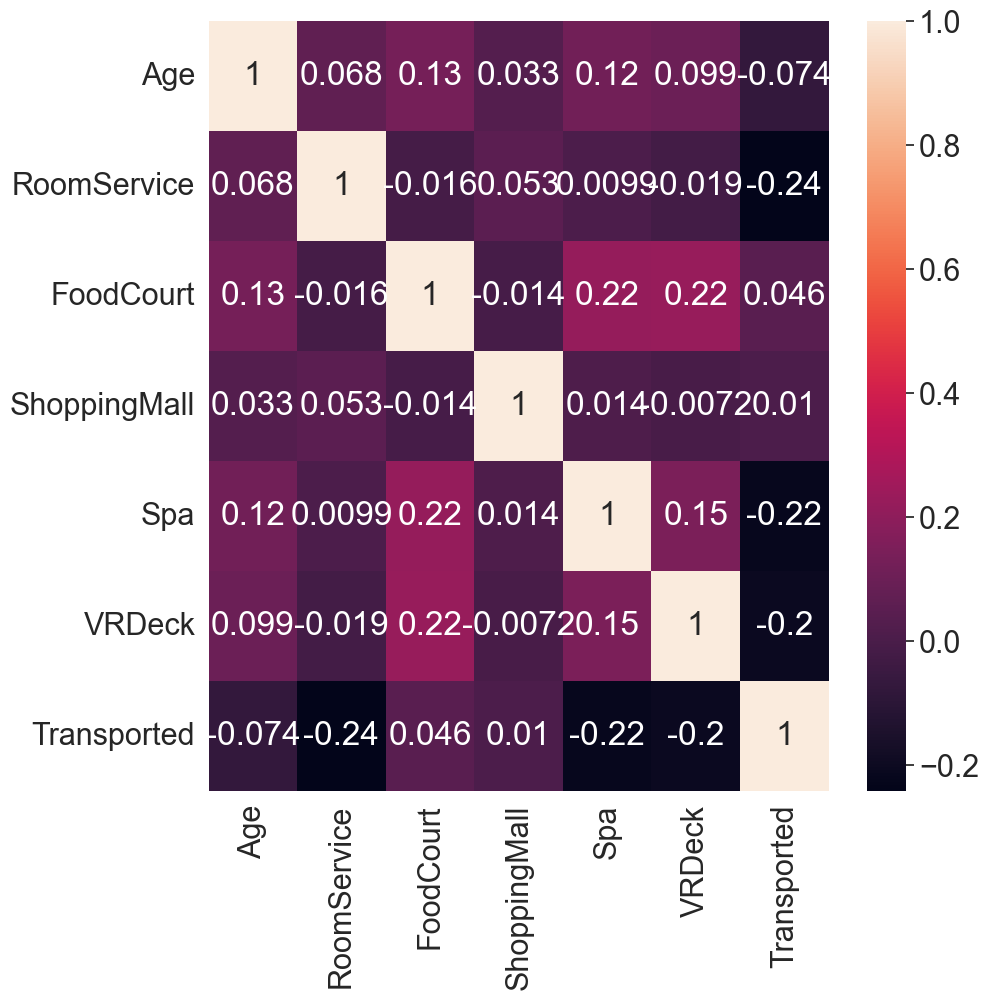

In [22]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True);

<AxesSubplot:>

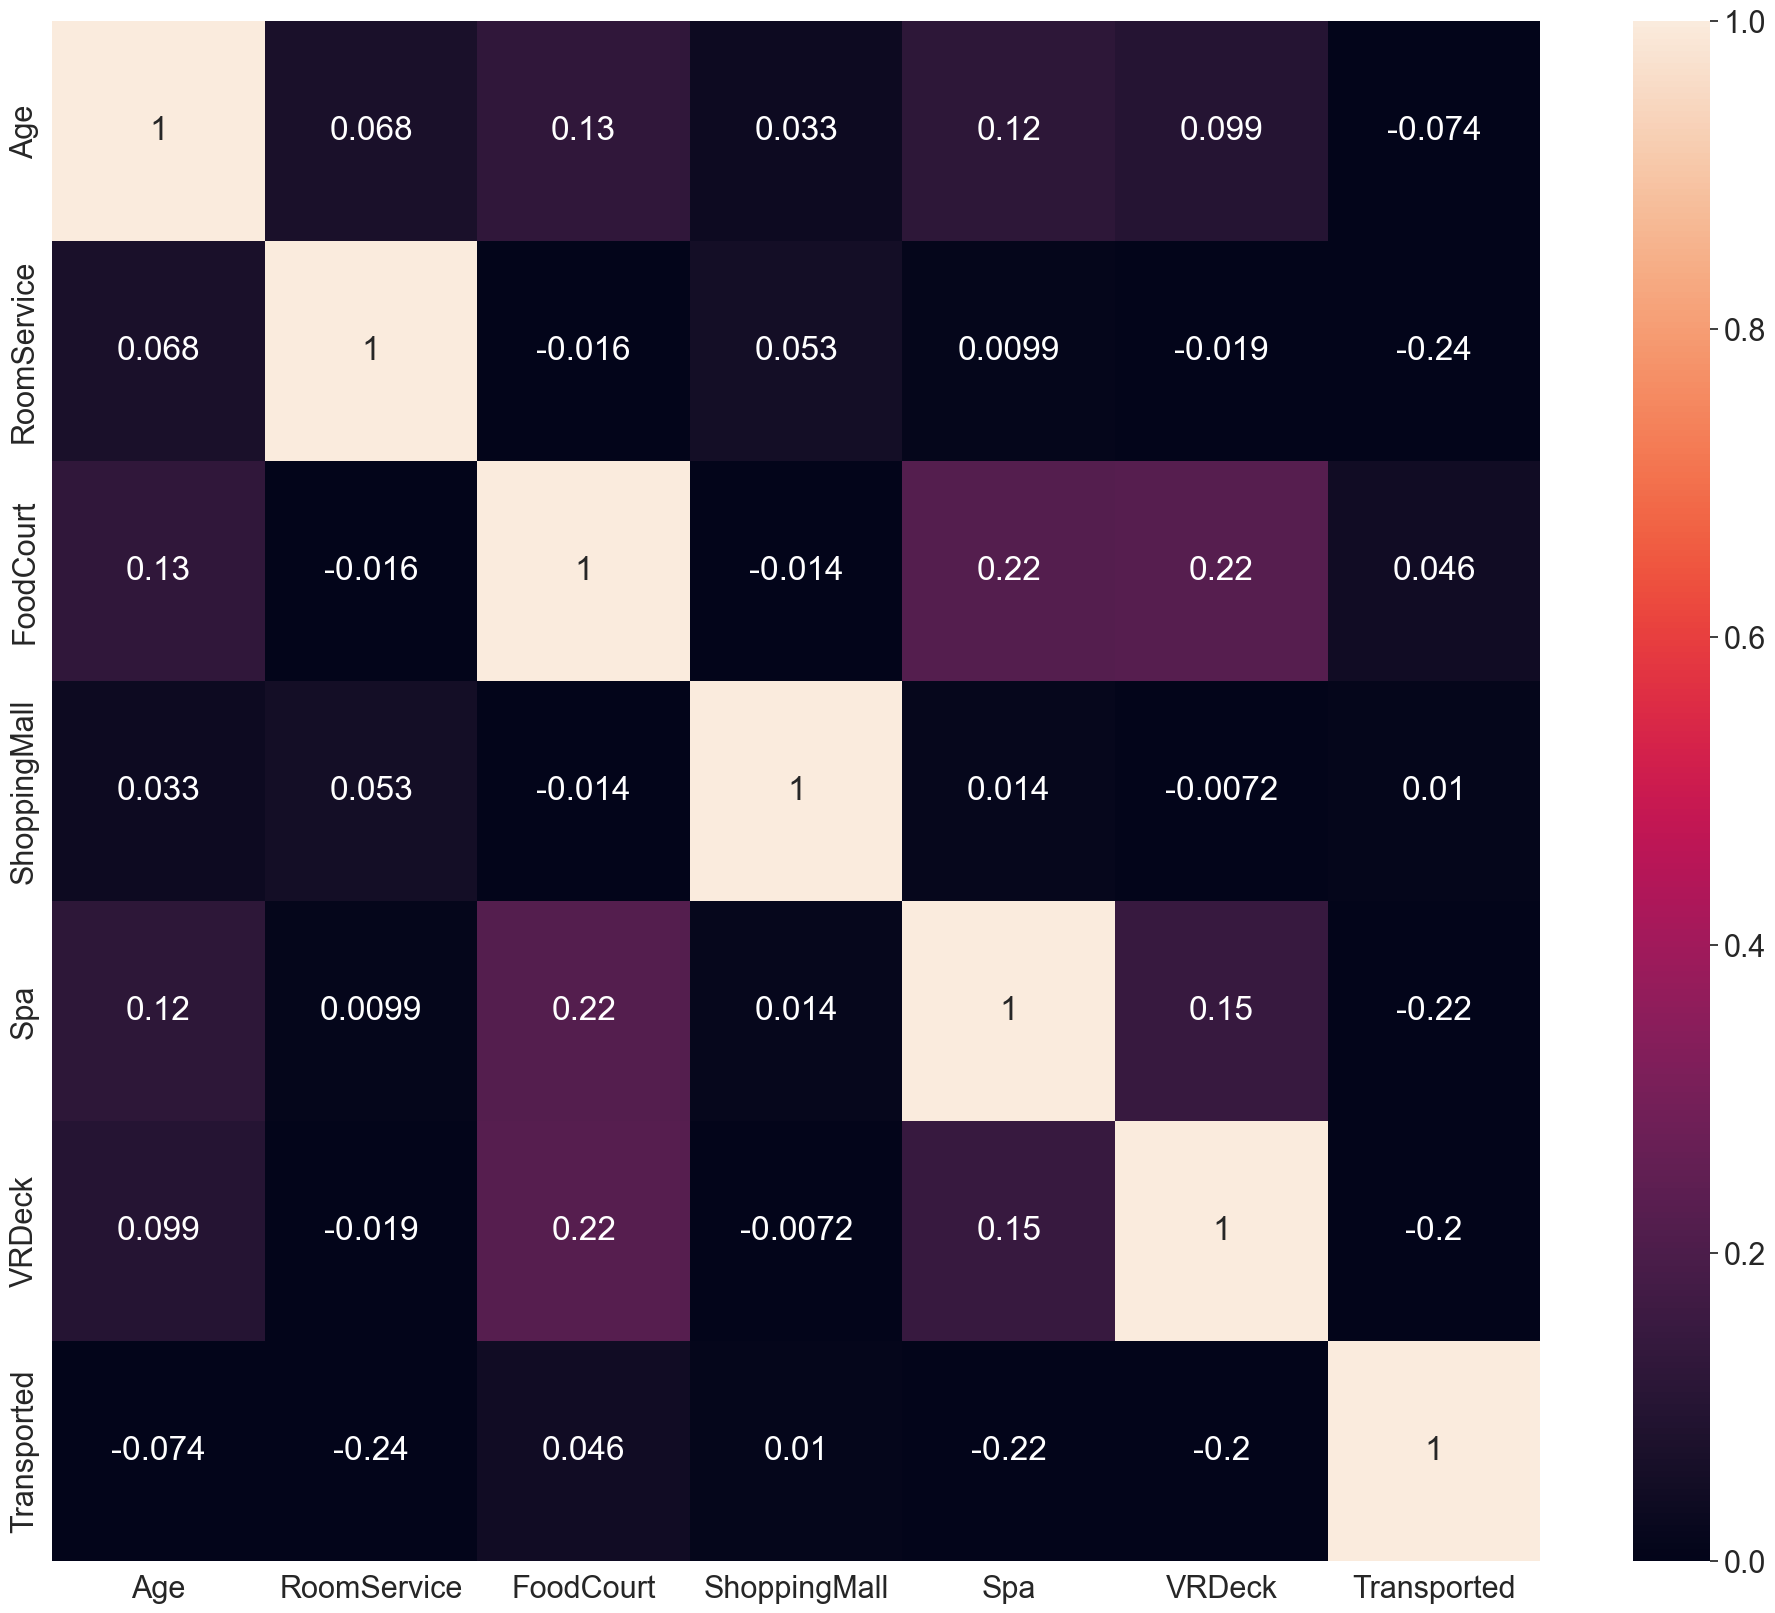

In [23]:
f = plt.figure(figsize=(24,20))
sns.heatmap(train.corr(),annot=True,vmin=0,vmax=1)


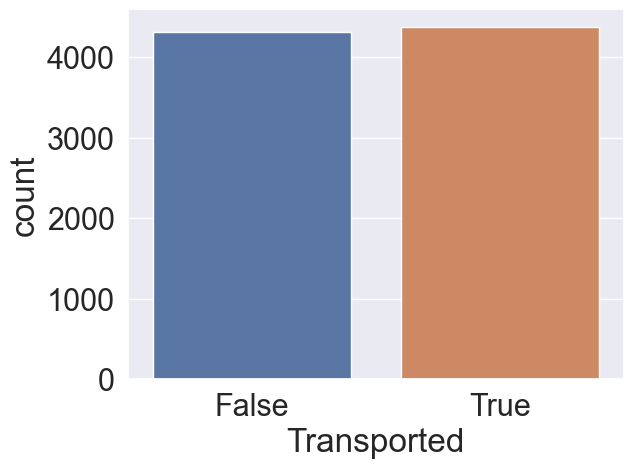

In [24]:
sns.countplot(train.Transported);

## Home Planet

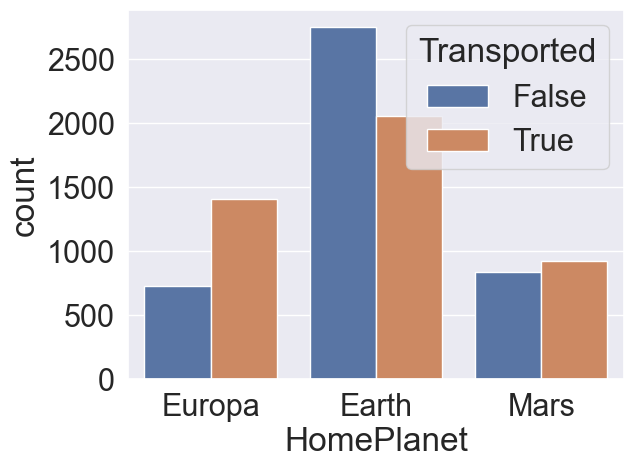

In [25]:
#passangers that survived depending on planet
sns.countplot(x='HomePlanet', hue='Transported', data=train);

## Cryosleep

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

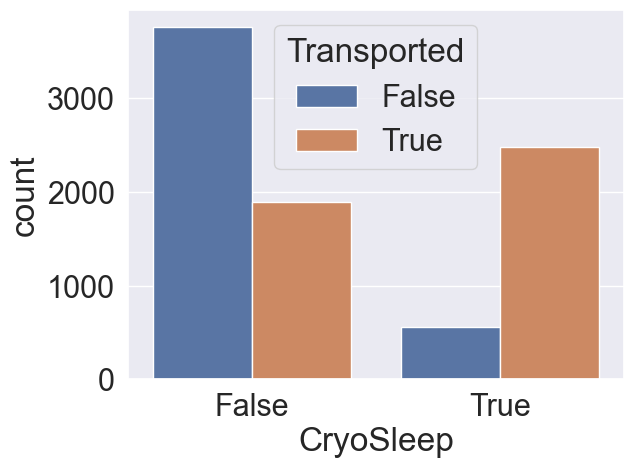

In [26]:
sns.countplot(x='CryoSleep', hue='Transported', data=train)


## Cabin

In [27]:
#passangers that survived depending on cabin
# fig, axs = plt.subplots(ncols=3, figsize=(12,5))

# sns.countplot(x='cabinDeck', hue='Transported', data=train, ax=axs[0])
# sns.countplot(x='cabinSide', hue='Transported', data=train, ax=axs[1])
# sns.countplot(x='cabinNum', hue='Transported', data=train, ax=axs[2])



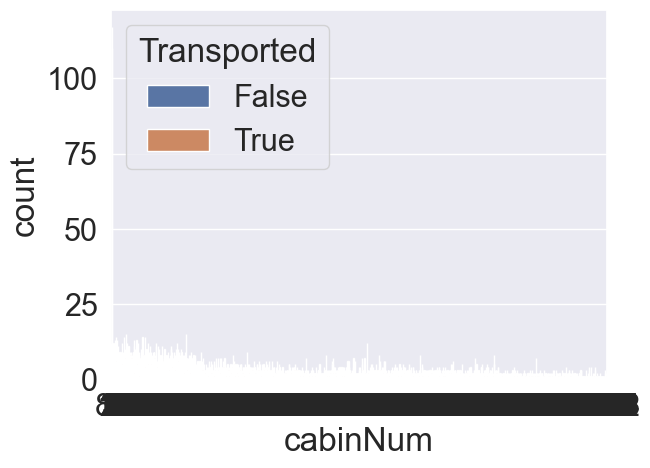

In [28]:
sns.countplot(x='cabinNum', hue='Transported', data=train);


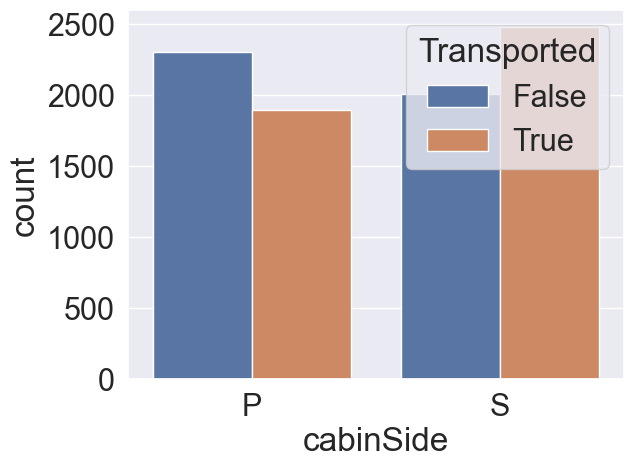

In [29]:
sns.countplot(x='cabinSide', hue='Transported', data=train);


<AxesSubplot:xlabel='cabinNum', ylabel='count'>

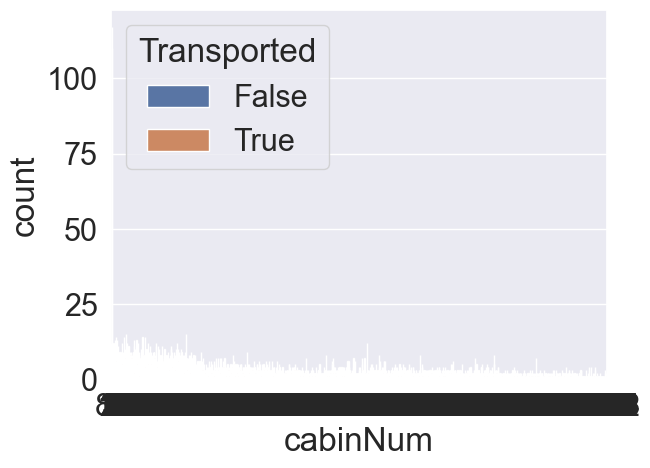

In [30]:
sns.countplot(x='cabinNum', hue='Transported', data=train)


## Destination

In [31]:
train['Destination'].value_counts()

TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='count'>

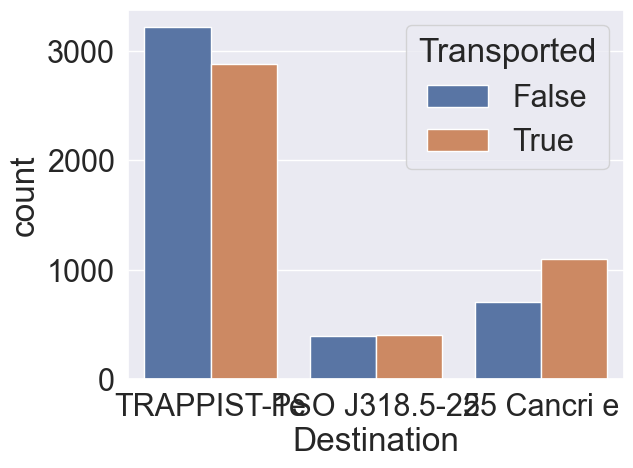

In [32]:

sns.countplot(x='Destination', hue='Transported', data=train)



## Age

<AxesSubplot:xlabel='Age', ylabel='Count'>

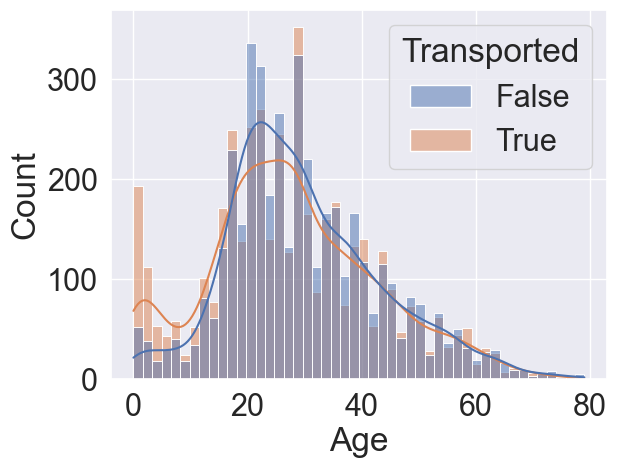

In [33]:
sns.histplot(data=train, x='Age', kde=True, hue='Transported')

In [34]:
train['Age'].mean()

28.827930467465347

In [35]:
#Create Age Groups
train['AgeGroup'] = 0
for i in range(6):
    train.loc[(train.Age >= 10*i) & (train.Age < 10*(i + 1)), 'AgeGroup'] = i

    
test['AgeGroup'] = 0
for i in range(6):
    test.loc[(test.Age >= 10*i) & (test.Age < 10*(i + 1)), 'AgeGroup'] = i

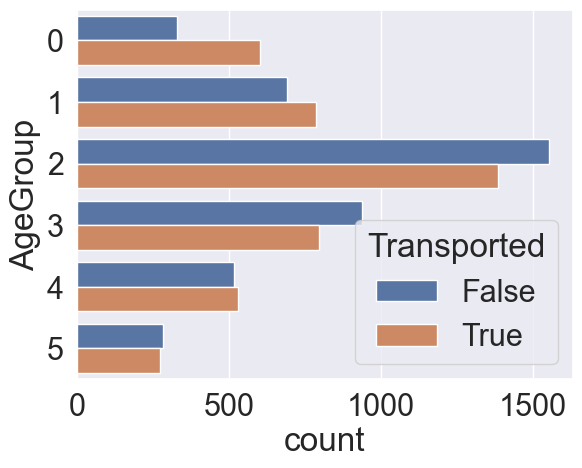

In [36]:
sns.countplot(y=train['AgeGroup'],hue=train['Transported']);

## VIP

In [37]:
percent_vip = (train['VIP']==1).sum() / train['VIP'].sum()

In [38]:
percent_vip

1.0

<AxesSubplot:xlabel='VIP', ylabel='count'>

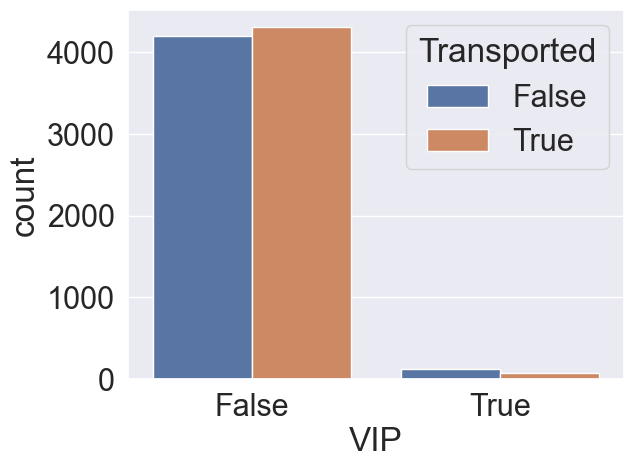

In [39]:
sns.countplot(x='VIP', hue='Transported', data=train)


## RoomService,	FoodCourt,	ShoppingMall,Spa, VRDec

In [40]:
train['SumSpending'] = train['ShoppingMall'] + train['FoodCourt'] + train['RoomService'] + train['VRDeck'] + train['Spa']

test['SumSpending'] = test['ShoppingMall'] + test['FoodCourt'] + test['RoomService'] + test['VRDeck'] + test['Spa']



<AxesSubplot:xlabel='SumSpending', ylabel='Count'>

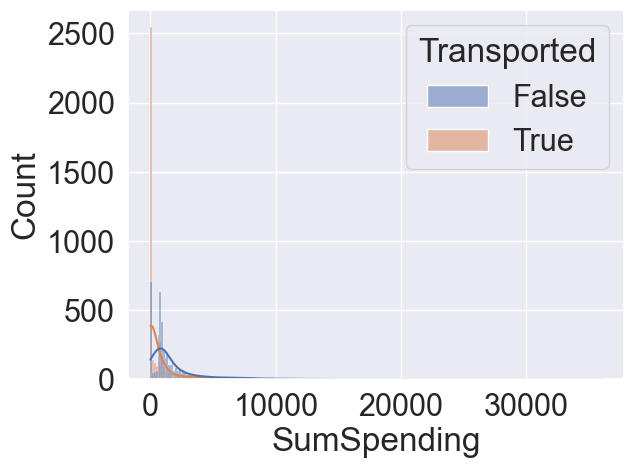

In [41]:
sns.histplot(data=train, x='SumSpending', kde=True , hue='Transported')

# Model Preprocessing

## Dropping Columns

In [92]:
train.drop(columns=['Cabin', 'Name'], inplace=True) # 'PassengerId'
test.drop(columns=['Cabin', 'Name'], inplace=True)

KeyError: "['Cabin', 'Name'] not found in axis"

In [43]:
train.head()

PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth     False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa     False  TRAPPIST-1e  58.0   True         43.0   
3     0003_02     Europa     False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth     False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported passengerGroup  \
0        0.0           0.0     0.0     0.0        False           0001   
1        9.0          25.0   549.0    44.0         True           0002   
2     3576.0           0.0  6715.0    49.0        False           0003   
3     1283.0         371.0  3329.0   193.0        False           0003   
4       70.0         151.0   565.0     2.0         True           0004   

  cabinDeck cabinNum cabinSide  AgeGroup  SumSpending  
0         B        0         P         3          0.0  
1         F        0         S         2        736.0  
2         A        0         S         5      10383.0  
3         A        0         S         3       5176.0  
4         F        1         S         1       1091.0

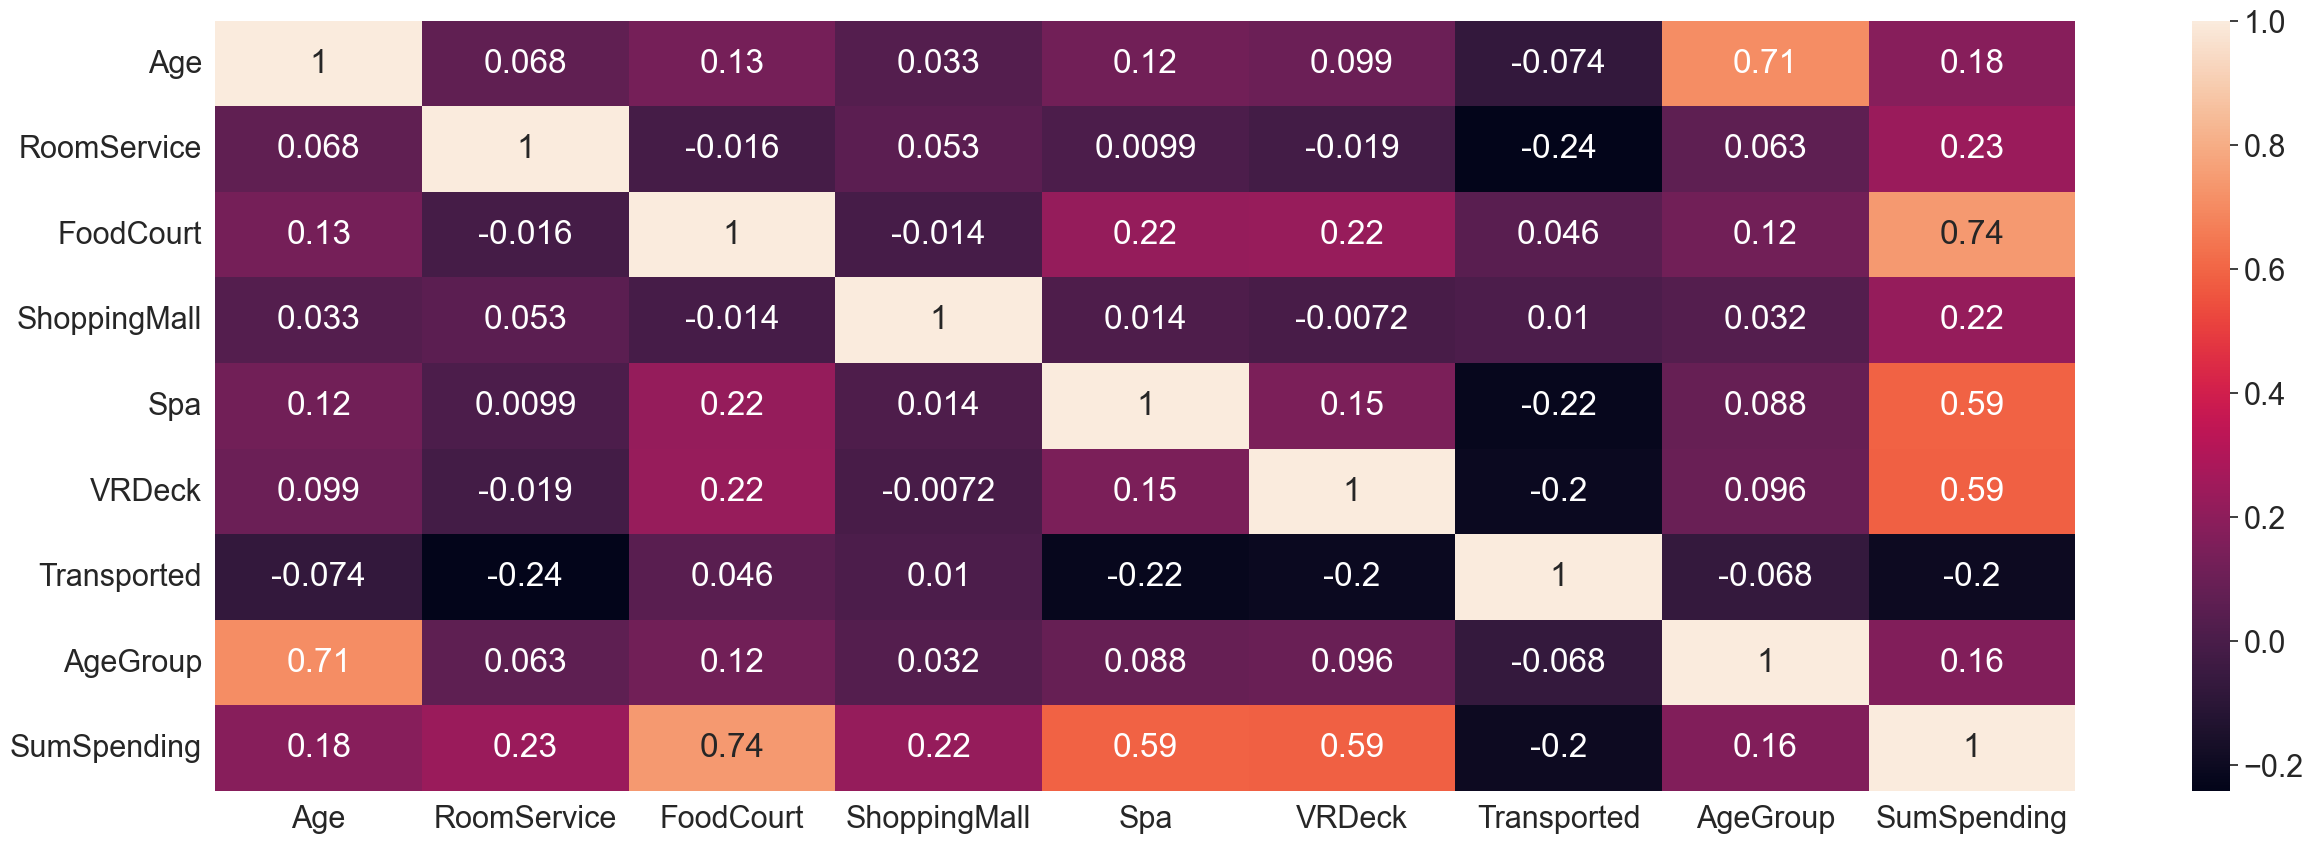

In [44]:
plt.figure(figsize=(30,10))
sns.heatmap(train.corr(), annot=True);

## Encode Columns

In [45]:
encode_cols = [ 'HomePlanet', 'CryoSleep', 'Destination',
       'VIP', 'cabinNum', 'cabinSide', 'cabinDeck']
encoder = OrdinalEncoder().fit(train[encode_cols])
train[encode_cols] = encoder.transform(train[encode_cols])


In [46]:
encoder2 = OrdinalEncoder().fit(test[encode_cols])
test[encode_cols] = encoder2.transform(test[encode_cols])


In [ ]:
train['Transported']=train['Transported'].replace({True:1,False:0})

## Set parameters and Split

In [91]:
# train['Transported']=train['Transported'].replace({True:1,False:0})

In [98]:
X = train.drop(columns=['Transported', 'PassengerId'], axis=1)
y = train['Transported']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Modelling

## Catboost

In [101]:
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=10,
                         eval_metric='Accuracy',
                        verbose=0)

In [102]:
model.fit(X_train,y_train)

In [103]:
print(model.predict_proba(X_test))

[[0.82992372 0.17007628]
 [0.16519655 0.83480345]
 [0.36317184 0.63682816]
 ...
 [0.06711855 0.93288145]
 [0.87648406 0.12351594]
 [0.86915977 0.13084023]]


In [104]:
expected_y  = y_test
predicted_y = model.predict(X_test)

In [105]:
pred_y=model.predict(X_test)

pred=model.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_test.values,pred_y))

0.8046014790468364
0.8094325153374233


In [106]:
from sklearn.model_selection import GridSearchCV
gcv=GridSearchCV(CatBoostClassifier(),param_grid={'iterations': range(200,2000,200), 'eval_metric': ['Accuracy'],'verbose':[0]},cv=3)
gcv.fit(X_train,y_train)
pred_y=gcv.predict(X_test)

pred=gcv.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_test.values,pred_y))

0.8903861955628595
0.8178680981595092


## Gradient Boost

In [109]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier(random_state=1,n_estimators=250,learning_rate=0.15,max_depth=3)
gb.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, random_state=1)

In [110]:
pred_y=gb.predict(X_test)
pred=gb.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_test.values,pred_y))

0.8701725554642563
0.8121165644171779


## Random Forest

In [111]:
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [112]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(rfc, X_train , y_train, cv=5)

In [114]:
cv_results['test_score'].mean()

0.7939194741166805

## Final Fit

The CatBoost model shows the highest accuracy scores, therefore I will fit it to the entire data

In [115]:
#fit cat to it
gcv.fit(X,y)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x13ddcbca0>,
             param_grid={'eval_metric': ['Accuracy'],
                         'iterations': range(200, 2000, 200), 'verbose': [0]})

# Prediction

In [119]:
y_pred = gcv.predict(test)

In [120]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [124]:
subission_df=pd.DataFrame({'Transported':y_pred.astype(bool)},index=test.index)

subission_df.head()

Transported
0         True
1        False
2         True
3         True
4        False

# Feature Selection

In [123]:
from sklearn.inspection import permutation_importance

permutation_score = permutation_importance(model, X_train, y_train, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) # Unstack results #new column headings

importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

feature score decrease
1        CryoSleep       0.032145
9           VRDeck       0.031241
6        FoodCourt        0.03083
8              Spa       0.029647
5      RoomService       0.021791
11       cabinDeck       0.018274
7     ShoppingMall       0.017239
12        cabinNum       0.006919
13       cabinSide       0.006508
0       HomePlanet       0.004979
10  passengerGroup       0.004749
15     SumSpending       0.004092
2      Destination       0.003353
3              Age       0.000181
4              VIP            0.0
14        AgeGroup      -0.000871